In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import sys
from tqdm import tqdm
sys.path.insert(0, os.getcwd() + '/code')
from viz import *
from helper_functions import * 

In [3]:
df_game = pd.read_csv("data/games.csv")
df_tracking = pd.read_csv("data/week1.csv")
df_tracking = compute_orientation(df_tracking)
df_play = pd.read_csv("data/plays.csv")
df_players = pd.read_csv("data/players.csv")
df_pffScoutingData = pd.read_csv("data/pffScoutingData.csv")

In [15]:
animate_play(df_tracking,df_play,df_players,df_pffScoutingData, 2021090900, 735, displayZone=True, displayOrientations=False).show()

 PlayId : 3364 - (2:03) (Shotgun) D.Prescott scrambles up the middle to TB 25 for 2 yards (D.White).


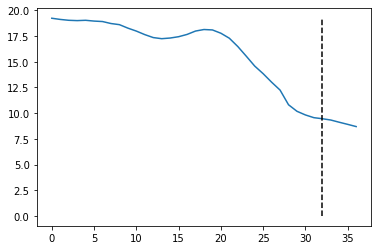

In [12]:
gameId = 2021090900
playId = 3364

playIds = df_play[df_play.gameId==gameId].playId.unique()
playIds.sort()
for playId in [3364]:#playIds[:5]:
    selected_play_df = df_play[(df_play.playId==playId)&(df_play.gameId==gameId)].copy()    
    tracking_players_df = pd.merge(df_tracking,df_players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,df_pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()
    selected_tracking_df = beaten_by_defender(gameId, playId, df_pffScoutingData, selected_tracking_df, seuil = 0.5)


    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()
    if selected_play_df.empty :
        print(playId)
        continue
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    print(f" PlayId : {playId} - {playDescription}")
    aire_t = list()
    if 'pass_forward' in selected_tracking_df.event.unique():
        eventFrame = selected_tracking_df[selected_tracking_df.event == 'pass_forward'].iloc[0].frameId
    else :
        eventFrame = 1000
    for frameId in sorted_frame_list:
        #if eventFrame == frameId :
        #    break
        selected_frame_df = selected_tracking_df[selected_tracking_df.frameId == frameId]
        offensive_points = get_Oline_position(selected_frame_df)
        defensive_points = get_Dline_position(selected_frame_df)
        QB_zone = calculate_Oline_zones(offensive_points, line_of_scrimmage)
        region_polys, region_pts, players_points = calculate_voronoi_zones(QB_zone, offensive_points, defensive_points)
        aire_t.append(pocketArea(region_polys, region_pts, players_points))

    plt.plot(aire_t)
    plt.vlines(eventFrame, 0, np.max(aire_t), color = 'black', linestyles='--',)
    plt.show()
    

  0%|          | 0/97 [00:00<?, ?it/s]

 PlayId : 2279 - (1:11) (Shotgun) D.Prescott sacked at TB 33 for -12 yards (S.Barrett).


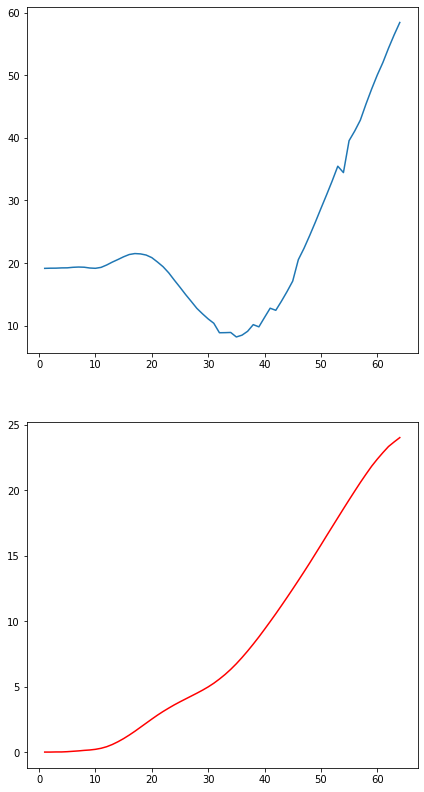

 45%|████▌     | 44/97 [00:08<00:10,  5.02it/s]

 PlayId : 2330 - (:28) (Shotgun) D.Prescott scrambles left end pushed ob at TB 42 for 1 yard (S.Barrett; W.Gholston). TB-W.Gholston was injured during the play. His return is Questionable. 


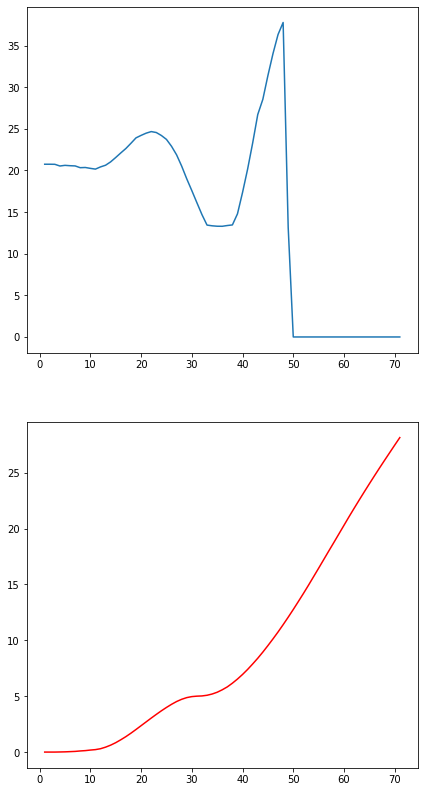

 47%|████▋     | 46/97 [00:17<00:22,  2.24it/s]

 PlayId : 3364 - (2:03) (Shotgun) D.Prescott scrambles up the middle to TB 25 for 2 yards (D.White).


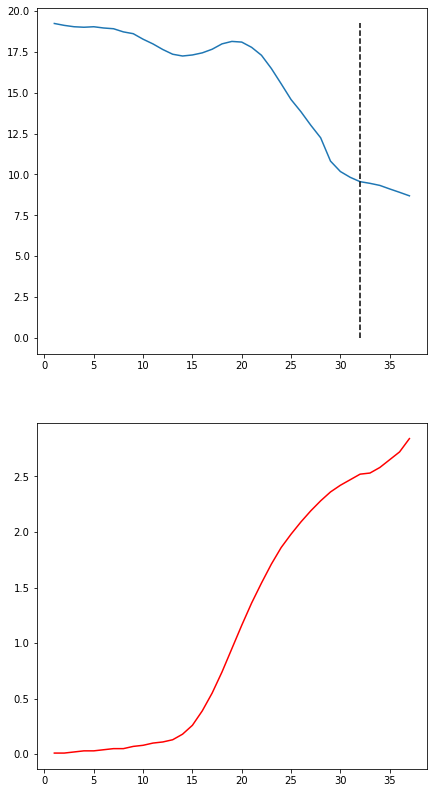

100%|██████████| 97/97 [00:23<00:00,  4.17it/s]


In [13]:
gameId = 2021090900

playIds = df_play[df_play.gameId==gameId].playId.unique()
playIds.sort()
for playId in tqdm(playIds):
    selected_play_df = df_play[(df_play.playId==playId)&(df_play.gameId==gameId)].copy()  
    if 'SCRAMBLE' in selected_play_df.dropBackType.unique():  
        tracking_players_df = pd.merge(df_tracking,df_players,how="left",on = "nflId")
        tracking_players_df = pd.merge(tracking_players_df,df_pffScoutingData,how="left",on = ["nflId","playId","gameId"])
        selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()
        selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()
        selected_tracking_df = beaten_by_defender(gameId, playId, df_pffScoutingData, selected_tracking_df, seuil = 0.5)

        sorted_frame_list = selected_tracking_df.frameId.unique()
        sorted_frame_list.sort()
        if selected_play_df.empty :
            print(playId)
            continue
        line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
        playDescription = selected_play_df.playDescription.values[0]
        print(f" PlayId : {playId} - {playDescription}")

        QB_dis_list = list(selected_tracking_df[selected_tracking_df.officialPosition == "QB"].dis)
        QB_dis_covered = [QB_dis_list[0]] + [np.sum(QB_dis_list[:k]) for k in range(1,len(QB_dis_list))]
        aire_t = list()

        for frameId in sorted_frame_list:
            #if eventFrame == frameId :
            #    break
            selected_frame_df = selected_tracking_df[selected_tracking_df.frameId == frameId]
            offensive_points = get_Oline_position(selected_frame_df)
            defensive_points = get_Dline_position(selected_frame_df)
            QB_zone = calculate_Oline_zones(offensive_points, line_of_scrimmage)
            region_polys, region_pts, players_points = calculate_voronoi_zones(QB_zone, offensive_points, defensive_points)
            aire_t.append(pocketArea(region_polys, region_pts, players_points))
        fig, ax = plt.subplots(2,1, figsize=(7,14))
        ax[0].plot(sorted_frame_list, aire_t)
        
        if 'pass_forward' in selected_tracking_df.event.unique():
            eventFrame = selected_tracking_df[selected_tracking_df.event == 'pass_forward'].iloc[0].frameId
            ax[0].vlines(eventFrame, 0, np.max(aire_t), color = 'black', linestyles='--',)
        else :
            eventFrame = 1000
        ax[1].plot(sorted_frame_list, QB_dis_covered, color = 'red')
        plt.show()
    

In [ ]:
print(f'Total n° of plays : {len(df_play)}')
scramble_mask = "'SCRAMBLE' in dropBackType | 'SCRAMBLE_ROLLOUT_RIGHT' in dropBackType | 'SCRAMBLE_ROLLOUT_LEFT' in dropBackType"
scramble_plays = df_play.query(scramble_mask)#[["gameId","playId","dropBackType"]]
print(f'n° of scramble plays : {len(scramble_plays)}')
for scramble_id in tqdm(range(len(scramble_plays))):

    scramble_play = scramble_plays.iloc[scramble_id].playId
    scramble_game = scramble_plays.iloc[scramble_id].gameId

    selected_play_df = df_play[(df_play.playId==scramble_play)&(df_play.gameId==scramble_game)].copy()  
    tracking_players_df = pd.merge(df_tracking,df_players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,df_pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==scramble_play)&(tracking_players_df.gameId==scramble_game)].copy()
    selected_tracking_df = beaten_by_defender(scramble_game, scramble_play , df_pffScoutingData, selected_tracking_df, seuil = 0.5)
    selected_tracking_df = scramble(scramble_game, scramble_play , df_pffScoutingData, selected_tracking_df, seuil = 0.5)
    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()
    if selected_play_df.empty :
        print(playId)
        continue
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    print(f" PlayId : {scramble_game} - {scramble_play} - {playDescription}")

    QB_dis_list = list(selected_tracking_df[selected_tracking_df.officialPosition == "QB"].dis)
    QB_dis_covered = [QB_dis_list[0]] + [np.sum(QB_dis_list[:k]) for k in range(1,len(QB_dis_list))]
    aire_t = list()

    for frameId in sorted_frame_list:
        #if eventFrame == frameId :
        #    break
        selected_frame_df = selected_tracking_df[selected_tracking_df.frameId == frameId]
        offensive_points = get_Oline_position(selected_frame_df)
        defensive_points = get_Dline_position(selected_frame_df)
        QB_zone = calculate_Oline_zones(offensive_points, line_of_scrimmage)
        region_polys, region_pts, players_points = calculate_voronoi_zones(QB_zone, offensive_points, defensive_points)
        aire_t.append(pocketArea(region_polys, region_pts, players_points))
    aire_min_during_scramble = np.min(aire_t)
    scramble_plays.loc[scramble_id, 'scrambleArea'] = aire_min_during_scramble
#print(scramble_plays[['gameId','playId','scrambleArea']])

    plt.plot(sorted_frame_list, aire_t)

    if 'pass_forward' in selected_tracking_df.event.unique():
        eventFrame = selected_tracking_df[selected_tracking_df.event == 'pass_forward'].iloc[0].frameId
        plt.vlines(eventFrame, 0, np.max(aire_t), color = 'black', linestyles='--',)
    else :
        eventFrame = 1000
    plt.show()


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import sys
from tqdm import tqdm
sys.path.insert(0, os.getcwd() + '/code')
from viz import *
from helper_functions import * 
from multiprocessing import Pool
from scipy.signal import argrelextrema

df_game = pd.read_csv("data/games.csv")
df_tracking = pd.read_csv("data/week1.csv")
df_tracking = compute_orientation(df_tracking)
df_play = pd.read_csv("data/plays.csv")
df_players = pd.read_csv("data/players.csv")
df_pffScoutingData = pd.read_csv("data/pffScoutingData.csv")


def features_one_play(playId) : 
    gameId = df_area[df_area.playId == playId].gameId.unique()[0]
    print(f'{playId} - {gameId}')
    selected_area_df = df_area[(df_area.playId==playId)&(df_area.gameId==gameId)].copy() 
    selected_play_df = df_play[(df_play.playId==playId)&(df_play.gameId==gameId)].copy()  
    tracking_players_df = pd.merge(df_tracking,df_players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,df_pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()
    selected_tracking_df = beaten_by_defender(gameId, playId , df_pffScoutingData, selected_tracking_df, seuil = 0.5)
    try :
        selected_tracking_df = scramble(gameId, playId, df_pffScoutingData, selected_tracking_df, seuil = 0.5)
        event, te = compute_t_event(gameId, playId, selected_play_df, df_pffScoutingData, selected_tracking_df)
        print(selected_area_df[selected_area_df.frameId < te].Area.values.tolist())
        Ae = selected_area_df[selected_area_df.frameId == te].Area.iloc[0]
        t_extrema = argrelextrema(np.array(selected_area_df[selected_area_df.frameId < te].Area.values.tolist()), np.greater)[0]
        print(t_extrema)
        if len(t_extrema) > 0 :
            tc = t_extrema[-1] + 1
            Ac = selected_area_df[selected_area_df.frameId == tc].Area.iloc[0]
            print(f'last local maxima : {Ac}')
        else :
            Ac = np.max(selected_area_df[selected_area_df.frameId <= te].Area)
            tc = selected_area_df[selected_area_df.Area == Ac].frameId.iloc[0]
            print(f'global maxima : {Ac}')
        one_play =  pd.DataFrame([[playId, gameId, event, te, Ae, tc, Ac]], 
                                columns = ['playId', 'gameId', 'event', 'te', 'Ae', 'tc', 'Ac'])
        #one_play.to_csv(f'data/area_features/plays/play{playId}_game{gameId}.csv')
        return one_play
    except : 
            print('Problème pour gameId, playId : ' + str((gameId, playId)))



df_tracking = pd.read_csv(f"data/week{1}.csv")
df_area = pd.read_csv(f"data/area/week{1}.csv")
playIds = [3364]#df_area.playId.unique()

with Pool() as mp_pool:
    week_features = mp_pool.map(features_one_play, playIds)
print(week_features)


3364 - 2021090900
[19.23324999999997, 19.117850000000026, 19.03400000000004, 19.00305000000004, 19.033999999999992, 18.95739999999998, 18.91260000000005, 18.71944999999996, 18.609200000000023, 18.270749999999985, 17.983700000000024, 17.63989999999998, 17.35234999999999, 17.24420000000002, 17.307999999999982, 17.437099999999937, 17.658000000000058, 17.986999999999984, 18.13630000000006, 18.095599999999955, 17.77489999999996, 17.289100000000026, 16.482150000000004, 15.542600000000007, 14.580549999999944, 13.838150000000056, 13.010699999999972, 12.24360000000005, 10.815497384670564, 10.178893994337688, 9.82369720980934]
[ 4 18]
last local maxima : 18.13630000000006
[   playId      gameId     event  te        Ae  tc       Ac
0    3364  2021090900  scramble  32  9.558656  19  18.1363]


In [13]:
df_area_1 = pd.read_csv(f"data/area/week{1}.csv")
df_area_2 = pd.read_csv(f"data/area/week{2}.csv")
df_area_3 = pd.read_csv(f"data/area/week{3}.csv")
df_area_4 = pd.read_csv(f"data/area/week{4}.csv")
df_area_5 = pd.read_csv(f"data/area/week{5}.csv")
df_area_6 = pd.read_csv(f"data/area/week{6}.csv")
df_area_7 = pd.read_csv(f"data/area/week{7}.csv")
df_area_8 = pd.read_csv(f"data/area/week{8}.csv")
print(len(df_area_1)+len(df_area_2)+len(df_area_3)+len(df_area_4)+len(df_area_5)+len(df_area_6)+len(df_area_7)+len(df_area_8))
print(df_area_1)
df_area_all_weeks = pd.concat([df_area_1,
                            df_area_2,
                            df_area_3,
                            df_area_4,
                            df_area_5,
                            df_area_6,
                            df_area_7,
                            df_area_8])

print(len(df_area_all_weeks))
print(df_area_all_weeks)
df_area_all_weeks.to_csv('data/area/area_t.csv')

361370
       Unnamed: 0  frameId       Area  playId      gameId
0               0        1  22.319900      97  2021090900
1               0        2  22.162750      97  2021090900
2               0        3  22.160150      97  2021090900
3               0        4  22.453350      97  2021090900
4               0        5  22.727850      97  2021090900
...           ...      ...        ...     ...         ...
48581           0       30  26.358933    4845  2021091300
48582           0       31  25.956274    4845  2021091300
48583           0       32  26.037736    4845  2021091300
48584           0       33  24.388550    4845  2021091300
48585           0       34  18.450469    4845  2021091300

[48586 rows x 5 columns]
361370
       Unnamed: 0  frameId       Area  playId      gameId
0               0        1  22.319900      97  2021090900
1               0        2  22.162750      97  2021090900
2               0        3  22.160150      97  2021090900
3               0        4  22.4